In [3]:
!pip install kaggle scikit-learn

In [4]:
# This uses the system's command line. The '!' runs it from inside the notebook.
!kaggle datasets download -d muthuj7/weather-dataset

# Unzip the downloaded file
!unzip -q weather-dataset.zip

print("Dataset 'weather-dataset' downloaded and unzipped.")

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Dhivyan Jeshua\anaconda3\Scripts\kaggle.exe\__main__.py", line 7, in <module>
    sys.exit(main())
             ~~~~^^
  File "C:\Users\Dhivyan Jeshua\anaconda3\Lib\site-packages\kaggle\cli.py", line 68, in main
    out = args.func(**command_args)
  File "C:\Users\Dhivyan Jeshua\anaconda3\Lib\site-packages\kaggle\api\kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\Dhivyan Jeshua\anaconda3\Lib\site-packages\kaggle\api\kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


Dataset 'weather-dataset' downloaded and unzipped.


'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- 1. Load Data ---
try:
    df_full = pd.read_csv('weatherHistory.csv')
except FileNotFoundError:
    print("Error: Could not find the weatherHistory.csv file.")
    raise

# --- 2. Clean and Set Index ---
# Convert date column to datetime objects
df_full['Formatted Date'] = pd.to_datetime(df_full['Formatted Date'], utc=True)

# Set the date as the index and sort the data
df_full = df_full.set_index('Formatted Date').sort_index()

# --- Handle duplicate index entries before resampling ---
# Keep the first occurrence of each timestamp
df_full = df_full[~df_full.index.duplicated(keep='first')]

# The data is hourly, but we resample to 'h' to fill any missing time steps
# We use 'interpolate' to fill gaps (e.g., missing hours)
# Using 'h' as 'H' is deprecated
df_full = df_full.resample('h').interpolate(method='time')

# --- 3. Select Features (X) and Target (Y) ---
N_FEATURES = 3
features = ['Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)']
target = 'Temperature (C)'

# Drop rows where our target or features are missing
df_clean = df_full[features + [target]].dropna()

X = df_clean[features].values
Y = df_clean[target].values.reshape(-1, 1)

print(f"Original data shape: {X.shape}")

# --- 4. Scale Data ---
# Standard practice for LSTMs is to scale features to [0, 1]
feature_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = feature_scaler.fit_transform(X)

# Scale the target (Temperature) to [0, 1]
target_scaler = MinMaxScaler(feature_range=(0, 1))
Y_scaled = target_scaler.fit_transform(Y)

# --- 5. Create Train/Test Split ---
# We must split time-series data sequentially
test_percent = 0.2
split_idx = int(len(Y_scaled) * (1 - test_percent))

X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
Y_train, Y_test = Y_scaled[:split_idx], Y_scaled[split_idx:]

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Original data shape: (96432, 3)
Training data shape: (77145, 3)
Test data shape: (19287, 3)


C:\Users\Dhivyan Jeshua\AppData\Local\Temp\ipykernel_42748\1071772387.py:26: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_full = df_full.resample('h').interpolate(method='time')


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error

# --- 1. Create Sequences for LSTM ---
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24 # Use 24 hours of history
X_seq_train, Y_seq_train = create_sequences(X_train, Y_train, TIME_STEPS)
X_seq_test, Y_seq_test = create_sequences(X_test, Y_test, TIME_STEPS)

# The shape will now be [samples, 24, 3]
print(f"Training sequences shape: {X_seq_train.shape}")
print(f"Test sequences shape: {X_seq_test.shape}")

# --- 2. Build the LSTM Model ---
model_lstm_simple = Sequential([
    # This Input shape is now (24, 3) automatically
    Input(shape=(TIME_STEPS, N_FEATURES)), 
    LSTM(units=50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, activation='relu'),
    Dropout(0.2),
    Dense(units=25, activation='relu'),
    Dense(units=1) 
])

# --- 3. Compile and Train ---
print("\n--- Training LSTM Model on SELECTED Features ---")
model_lstm_simple.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

history = model_lstm_simple.fit(
    X_seq_train, Y_seq_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_seq_test, Y_seq_test),
    shuffle=False,
    verbose=1
)
print("--- Model Training Complete ---")

# --- 4. Evaluate the LSTM Model ---
predictions_scaled = model_lstm_simple.predict(X_seq_test)
predictions_real = target_scaler.inverse_transform(predictions_scaled)
Y_test_real = target_scaler.inverse_transform(Y_seq_test)

rmse = np.sqrt(mean_squared_error(Y_test_real, predictions_real))
print(f"\n--- Model Evaluation ---")
print(f"Test RMSE: {rmse:.4f} (degrees C)")

Training sequences shape: (77121, 24, 3)
Test sequences shape: (19263, 24, 3)

--- Training LSTM Model on SELECTED Features ---
Epoch 1/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.0096 - val_loss: 0.0189
Epoch 2/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.0070 - val_loss: 0.0183
Epoch 3/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - loss: 0.0069 - val_loss: 0.0183
Epoch 4/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.0064 - val_loss: 0.0187
Epoch 5/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.0064 - val_loss: 0.0182
Epoch 6/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: 0.0064 - val_loss: 0.0180
Epoch 7/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - loss: 0.0065 - val_loss: 0.0178
Epoch 8/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 0.0064 - val_loss: 0.0181
Epoch 9/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 0.0065 - val_loss: 0.0186
Epoch 10/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - los

In [19]:
# --- 4. Evaluate the LSTM Model ---

# 1. MAKE PREDICTIONS
# Ask the trained model to predict the temperature for every sequence in the test set.
predictions_scaled = model_lstm_simple.predict(X_seq_test)

# 2. UN-SCALE THE DATA (Crucial Step)
# The predictions are scaled (e.g., 0.0 to 1.0). We must convert them
# back to the original units (degrees C) to understand them.
predictions_real = target_scaler.inverse_transform(predictions_scaled)
Y_test_real = target_scaler.inverse_transform(Y_seq_test)

# 3. CALCULATE THE ERROR
# Compare the list of "real predictions" to the list of "real actual values".
# This gives us the Root Mean Square Error (RMSE).
rmse = np.sqrt(mean_squared_error(Y_test_real, predictions_real))

# 4. PRINT THE RESULT
print(f"\n--- Model Evaluation ---")
print(f"Test RMSE: {rmse:.4f} (degrees C)")

602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

--- Model Evaluation ---
Test RMSE: 8.3199 (degrees C)


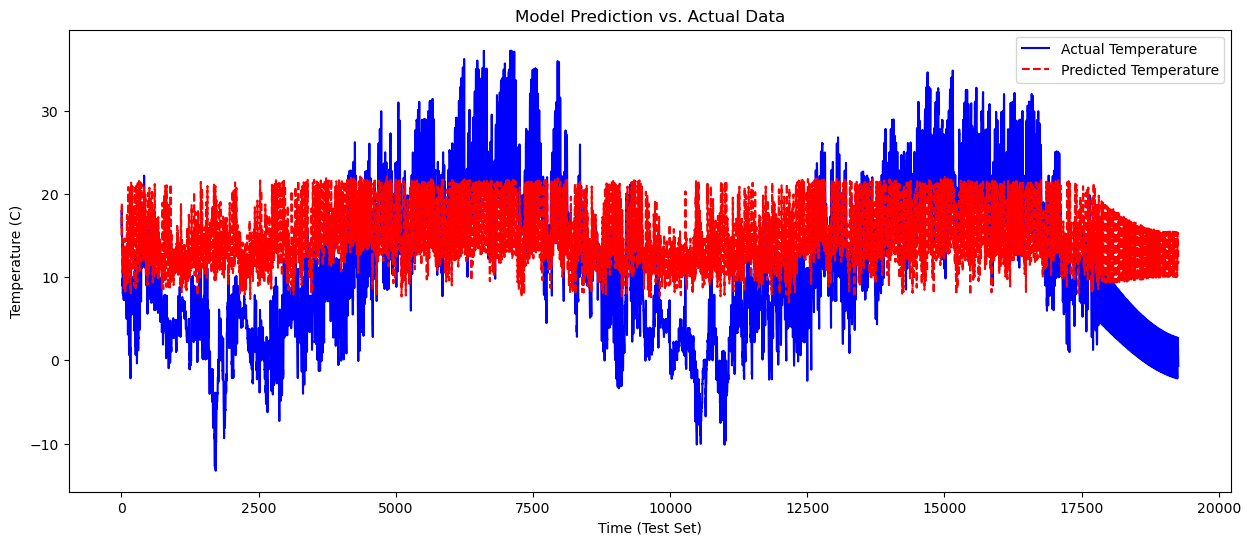

In [20]:
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(15, 6))

# Plot the "actual" (true) values from the test set
plt.plot(Y_test_real, label='Actual Temperature', color='blue')

# Plot the "predicted" values from your model
plt.plot(predictions_real, label='Predicted Temperature', color='red', linestyle='--')

# Add labels and a title
plt.title('Model Prediction vs. Actual Data')
plt.xlabel('Time (Test Set)')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()